<a href="https://colab.research.google.com/github/dibalaba/bad_buzz_detection/blob/main/models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install opendatasets --upgrade
!pip install mlflow
!pip install pyngrok
!pip install pyyaml
!pip install keras


In [4]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import opendatasets as od
import re
import nltk
import yaml
import matplotlib.pyplot as plt
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import mlflow
import pyngrok
import tensorflow as tf
## Visualization ##
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

## ML Modelling ##
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score)
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [5]:
from google.colab import drive
drive_path = "/content/gdrive"
drive.mount(drive_path)

# Load the general config
config_path = os.path.join(drive_path, "MyDrive", "general_config.yml")
with open(config_path, 'r') as yml:
  config = yaml.safe_load(yml)

config_github = config["github"]
config_ngrok = config["ngrok"]

# Set git configs
!git config --global user.email {config_github["email"]}
!git config --global user.name {config_github["username"]}

# Clone the repository
repository_name = "bad_buzz_detection"
git_repository = f"https://github.com/dibalaba/" + repository_name + ".git"
repository_path = "/content/" + repository_name
!git clone {git_repository}

# Change the current directory to the cloned directory
%cd {repository_name}

# Checkout branch
branch_name = "main"
!git checkout {branch_name}

# Pull
!git pull

Mounted at /content/gdrive
Cloning into 'bad_buzz_detection'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (3/3), done.
/content/bad_buzz_detection
Already on 'main'
Your branch is up to date with 'origin/main'.
Already up to date.


In [ ]:
dataset_url = 'https://www.kaggle.com/datasets/dowtadibalaba/sentiment-train'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dowtadibalaba
Your Kaggle Key: ··········


100%|██████████| 80.9M/80.9M [00:01<00:00, 65.4MB/s]


In [ ]:
df=pd.read_csv('./sentiment-train/training_sentiment.csv',encoding="ISO-8859-1",header=None,names=['target','id','date','flag','user','text'])
df.head(5)

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df.target.unique()

array([0, 4])

In [ ]:
df_pos=df.loc[df['target']== 4]
df_neg=df.loc[df['target']== 0]
df_pos['target'].replace(4, 1, inplace=True)
df=pd.concat([df_neg.sample(25000),df_pos.sample(25000)])


In [ ]:
df['target']

531826     0
193357     0
87713      0
185757     0
427682     0
          ..
1022613    1
870585     1
1348778    1
1551785    1
1042595    1
Name: target, Length: 50000, dtype: int64

In [ ]:
df.isna().sum()

target    0
id        0
date      0
flag      0
user      0
text      0
dtype: int64

In [ ]:
df.info

<bound method DataFrame.info of          target          id                          date      flag  \
531826        0  2196511693  Tue Jun 16 12:34:11 PDT 2009  NO_QUERY   
193357        0  1970057176  Sat May 30 02:16:39 PDT 2009  NO_QUERY   
87713         0  1754573707  Sun May 10 06:43:31 PDT 2009  NO_QUERY   
185757        0  1968141993  Fri May 29 20:50:25 PDT 2009  NO_QUERY   
427682        0  2063780573  Sun Jun 07 04:02:50 PDT 2009  NO_QUERY   
...         ...         ...                           ...       ...   
1022613       1  1882834643  Fri May 22 07:33:55 PDT 2009  NO_QUERY   
870585        1  1678414219  Sat May 02 06:37:50 PDT 2009  NO_QUERY   
1348778       1  2045030860  Fri Jun 05 10:08:15 PDT 2009  NO_QUERY   
1551785       1  2184207695  Mon Jun 15 15:34:32 PDT 2009  NO_QUERY   
1042595       1  1957218204  Thu May 28 23:51:24 PDT 2009  NO_QUERY   

                user                                               text  
531826    Beanerific       wondering when

In [ ]:
df_copy=df
data=df.drop(columns=[ 'id', 'date', 'flag', 'user'])

In [ ]:
data

,target,text
750798,0,If there's a dude out there who wants this to ...
687399,0,Still has that head ache.
116272,0,@Branden_Kyle god I wish I could do that but I...
778124,0,Aduuuuuh...telat bayar credit card!!!kena dend...
775763,0,@goodgirlgonbad_ awwwwwwww cheerrr up !
...,...,...
1052995,1,@tonyhawk &quot;doing&quot; jimmy fallon! haha...
1241977,1,@tyk505 I wanna win a cruise trip with y'all! ...
1050739,1,Jonas Brothers Movie is thee best !!!
1483258,1,At ITricks Frequency - http://www.itricks.com/...


In [ ]:
data['target'].value_counts()

0    25000
1    25000
Name: target, dtype: int64

In [ ]:
data['target'].unique()

array([0, 1])

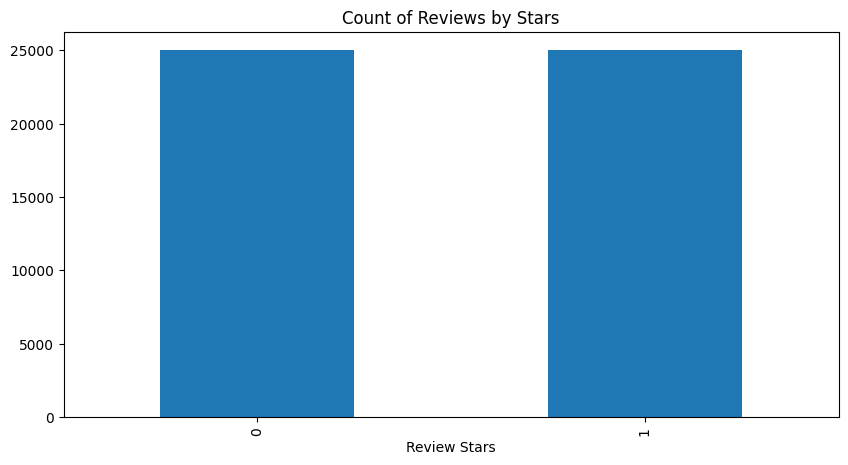

In [ ]:
ax = data['target'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

In [ ]:
from google.colab import drive
drive_path = "/content/gdrive"
drive.mount(drive_path,force_remount=True)

# Load the general config
contractions_path = os.path.join(drive_path, "MyDrive", "contractions.json")
with open(contractions_path, 'r') as yml:
  contractions = yaml.safe_load(yml)



Mounted at /content/gdrive


In [ ]:
def text_preprocessing(text):
    import json
    #contractions_path = os.path.join(drive_path, "MyDrive", "contractions.json")
    #with open(contractions_path, 'r') as yml:
     #contractions = yaml.safe_load(yml)

    #with open('/content/contractions.json', 'r') as f:
    # contractions = json.loads(f.read())
    # Convert words to lower case
    text = text.lower()

    # Expand contractions
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)

    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text)
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)

    # Tokenize each word
    text = nltk.WordPunctTokenizer().tokenize(text)

    # Lemmatize each word
    text = [nltk.stem.WordNetLemmatizer().lemmatize(token, pos='v') for token in text if len(token)>1]
    #text= (x.lower() for x in text)

    return str(text)

In [ ]:
df_target= data['target']
#df_text=data['text'].apply(lambda x:x.lower())
#df_text=data['text'].apply(lambda x:text_preprocessing(x))
df_text.head()

695714    ['wish', 'everyone', 'very', 'happy', 'and', '...
71465                        ['dragonflly93', 'they', 'do']
305109    ['shannynb', 'jenelle', 'hardly', 'touch', 'he...
543235    ['fillerwriter', 'quot', 'and', 'then', 'get',...
722378    ['be', 'not', 'so', 'great', 'at', 'this', 'st...
Name: text, dtype: object

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score
def simple_model(experiment_name: str, run_name: str):



        # Fix and log seed value
        seed=123
        np.random.seed(seed)
        #mlflow.log_param("numpy seed", seed)




        # Defines ratios, w.r.t. whole dataset.
        ratio_train = 0.8
        ratio_val = 0.1
        ratio_test = 0.1
        #mlflow.log_param("train size", ratio_train)
        #mlflow.log_param("test size", ratio_test)
        #mlflow.log_param("validation size", ratio_val)

        # Produces test split.
        x_remaining, x_test, y_remaining, y_test = train_test_split(
            df_text, df_target, test_size=ratio_test)

        # Adjusts val ratio, w.r.t. remaining dataset.
        ratio_remaining = 1 - ratio_test
        ratio_val_adjusted = ratio_val / ratio_remaining
        x_train, x_val, y_train, y_val = train_test_split(
                x_remaining, y_remaining, test_size=ratio_val_adjusted)
        mlflow.end_run()
        # Produces train and val splits.
        mlflow.set_experiment(experiment_name)
        with mlflow.start_run(run_name=run_name):
            #mlflow.log_param("numpy seed", seed)
            #mlflow.log_param("train size", ratio_train)
            #mlflow.log_param("test size", ratio_test)
            #mlflow.log_param("validation size", ratio_val)

        # Log automatically
            mlflow.sklearn.autolog()

            vectorizer = TfidfVectorizer()
            x_train_vectorized = vectorizer.fit_transform(x_train)
            x_test_vectorized = vectorizer.transform(x_test)
            x_val_vectorized  = vectorizer.transform(x_val)

            naive_bayes = MultinomialNB()
            naive_bayes.fit(x_train_vectorized, y_train)
            mlflow.log_param("validation size", ratio_val)
            scores = cross_val_score(naive_bayes,x_val_vectorized,y_val, cv = 10, scoring='accuracy')
            print(scores)
            #test_predicted = np.argmax(analyser.predict(x_test_vectorized), axis=0)
            test_predicted = naive_bayes.predict(x_test_vectorized)
            accuracy=accuracy_score(y_test, test_predicted, normalize=True)
            f1_Score= f1_score(y_test, test_predicted)
            #accuracy = sum(test_predicted == y_test) / len(test_predicted)
            mlflow.log_metric("accuracy", accuracy)
            mlflow.log_metric("f1_Score", f1_Score)

            #print(f"accuracy is {accuracy}.")

In [ ]:
simple_model('first model','basic run')

2023/09/22 07:03:09 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'
2023/09/22 07:03:12 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'
2023/09/22 07:03:15 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'
2023/09/22 07:03:18 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'
2023/09/22 07:03:21 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'
2023/09/22 07:03:24 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'
2023/09/22 07:03:27 WARNING mlflow.sklearn: Failed t

[0.718 0.718 0.714 0.752 0.708 0.722 0.716 0.684 0.674 0.708]


In [ ]:
def regLog_model(experiment_name: str, run_name: str):



        # Fix and log seed value
        seed=123
        np.random.seed(seed)
        mlflow.log_param("numpy seed", seed)




        # Defines ratios, w.r.t. whole dataset.
        ratio_train = 0.8
        ratio_val = 0.1
        ratio_test = 0.1
        #mlflow.log_param("train size", ratio_train)
        #mlflow.log_param("test size", ratio_test)
        #mlflow.log_param("validation size", ratio_val)

        # Produces test split.
        x_remaining, x_test, y_remaining, y_test = train_test_split(
            df_text, df_target, test_size=ratio_test)

        # Adjusts val ratio, w.r.t. remaining dataset.
        ratio_remaining = 1 - ratio_test
        ratio_val_adjusted = ratio_val / ratio_remaining
        x_train, x_val, y_train, y_val = train_test_split(
                x_remaining, y_remaining, test_size=ratio_val_adjusted)


        mlflow.end_run()
        # Produces train and val splits.
        mlflow.set_experiment(experiment_name)
        with mlflow.start_run(run_name=run_name):
        # Log automatically
            mlflow.sklearn.autolog()
            vectorizer = TfidfVectorizer()
            x_train_vectorized = vectorizer.fit_transform(x_train)
            x_test_vectorized = vectorizer.transform(x_test)
            x_val_vectorized  = vectorizer.transform(x_val)


            analyser=LogisticRegressionCV(cv=5,
                      scoring='accuracy',
                      random_state=0,
                      n_jobs=-1,
                      verbose=3,
                      max_iter=300)
            analyser.fit(x_train_vectorized, y_train)

            scores = cross_val_score(analyser,x_val_vectorized,y_val, cv = 10, scoring='accuracy')
            mlflow.log_param("score", scores)
            print(scores)
            #test_predicted = np.argmax(analyser.predict(x_test_vectorized), axis=0)
            test_predicted = analyser.predict(x_test_vectorized)
            accuracy=accuracy_score(y_test, test_predicted, normalize=True)
            f1_Score= f1_score(y_test, test_predicted)
            mlflow.log_metric("accuracy", accuracy)
            mlflow.log_metric("f1_Score", f1_Score)

In [ ]:
regLog_model('run logistic regression','log reg')

2023/09/22 07:05:22 INFO mlflow.tracking.fluent: Experiment with name 'run logistic regression' does not exist. Creating a new experiment.
2023/09/22 07:05:25 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   23.2s remaining:   34.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.7s finished
2023/09/22 07:05:57 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.9s remaining:   19.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.0s finished
2023/09/22 07:06:15 WARNING mlflow.sklearn: Failed to log training dataset information to

[0.736 0.746 0.732 0.77  0.742 0.756 0.7   0.738 0.738 0.734]


In [ ]:
data

,target,text
652378,0,@sweetmistake08 no comp in Pansol kaya I dont...
301423,0,is anybody using an api (apart from TweetDeck)...
607661,0,Walking to the Sky must be a huge lightning ro...
684393,0,@OmniPax ur lucky. I love coffee but if I drin...
305830,0,The Up movie is really racist. They put the bl...
...,...,...
1255509,1,@GrasieMercedes record for me- I know you will
1269409,1,@CosmoPolitician might want to fix your @houst...
1139366,1,"@sarahvaughnlo Well sarah, he had his chance a..."
908025,1,@Heart_song Glad you had a wondrous Beltaine! ...


In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import numpy as np
training_data=np.array([["I am brave."],["I am a student"],["I study at school"]])
print(training_data)

vectorizer=TextVectorization(output_mode="tf-idf")
vectorizer.adapt(training_data)

dat = vectorizer(training_data)
print(dat)

[['I am brave.']
 ['I am a student']
 ['I study at school']]
tf.Tensor(
[[0.         0.5596158  0.6931472  0.         0.         0.
  0.91629076 0.         0.        ]
 [0.         0.5596158  0.6931472  0.         0.91629076 0.
  0.         0.         0.91629076]
 [0.         0.5596158  0.         0.91629076 0.         0.91629076
  0.         0.91629076 0.        ]], shape=(3, 9), dtype=float32)


In [ ]:

def rnn_model2(experiment_name: str, run_name: str):



        # Fix and log seed value
        seed=123
        np.random.seed(seed)
        mlflow.log_param("numpy seed", seed)




        # Defines ratios, w.r.t. whole dataset.
        ratio_train = 0.8
        ratio_val = 0.1
        ratio_test = 0.1
        #mlflow.log_param("train size", ratio_train)
        #mlflow.log_param("test size", ratio_test)
        #mlflow.log_param("validation size", ratio_val)

        # Produces test split.
        x_remaining,x_test= train_test_split(data, test_size=ratio_test, random_state=42, shuffle=True)

        #train, test = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)

        # Adjusts val ratio, w.r.t. remaining dataset.
        ratio_remaining = 1 - ratio_test
        ratio_val_adjusted = ratio_val / ratio_remaining
        mlflow.end_run()
        # Produces train and val splits.
        x_train, x_val = train_test_split(
                x_remaining, test_size=ratio_val_adjusted)

        VOCAB_SIZE = 1000
        encoder = tf.keras.layers.TextVectorization(
        max_tokens=VOCAB_SIZE)
        encoder.adapt(x_train.map(lambda target,text: text))
        mlflow.set_experiment(experiment_name)
        with mlflow.start_run(run_name=run_name):
        # Log automatically
          model = tf.keras.Sequential([
            encoder,
            tf.keras.layers.Embedding(
                input_dim=len(encoder.get_vocabulary()),
                output_dim=64,
                # Use masking to handle the variable sequence lengths
                mask_zero=True),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(1)
             ])
          test_loss, test_acc = model.evaluate(x_test)

          print('Test Loss:', test_loss)
          print('Test Accuracy:', test_acc)

In [ ]:
rnn_model2('rnn_model2','rnn_model2')

TypeError: ignored

In [ ]:
# helps in text preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# helps in model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
# split data into train and test set
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def c_report(y_true, y_pred):
   print("Classification Report")
   print(classification_report(y_true, y_pred))
   acc_sc = accuracy_score(y_true, y_pred)
   print("Accuracy : "+ str(acc_sc))
   return acc_sc

def plot_confusion_matrix(y_true, y_pred):
   mtx = confusion_matrix(y_true, y_pred)
   sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5,
               cmap="Blues", cbar=False)
   plt.ylabel('True label')
   plt.xlabel('Predicted label')

In [ ]:
data

,target,text
681155,0,"is bored, bored, bored, but not sleepy"
76096,0,@susan_adrian *hugs* and ice cream and ~feel ...
519635,0,Starting to get sick.
679624,0,Finally set newport free. Extremely hard but i...
310033,0,soon man...hows t.dot/DPC? lydia is always too...
...,...,...
847886,1,"I love Pandora Radio, it helps get my day star..."
803898,1,Is on Twiiterr yaay. I dont know how to use i...
1557592,1,@Aussie_MateLC its all good! I'm listening to ...
1342852,1,Model of the day is Karen. Another one of my f...


In [ ]:
def rnn_model(experiment_name: str, run_name: str):
    X = data['text'].values
    y = data['target'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    mlflow.end_run()
        # Produces train and val splits.
    mlflow.set_experiment(experiment_name)
    with mlflow.start_run(run_name=run_name):
      mlflow.sklearn.autolog()
      t = Tokenizer()
      t.fit_on_texts(X_train)

      encoded_train = t.texts_to_sequences(X_train)
      encoded_test = t.texts_to_sequences(X_test)
      print(encoded_train[0:2])

      max_length = 8
      padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')
      padded_test = pad_sequences(encoded_test, maxlen=max_length, padding='post')
      print(padded_train)

      vocab_size = len(t.word_index) + 1

      # define the model
      model = Sequential()
      model.add(Embedding(vocab_size, 24, input_length=max_length))
      model.add(SimpleRNN(24, return_sequences=False))
      model.add(Dense(1, activation='sigmoid'))

      # compile the model
      model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

      # summarize the model
      print(model.summary())

      early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

      # fit the model
      model.fit(x=padded_train,
         y=y_train,
         epochs=100,
         validation_data=(padded_test, y_test), verbose=1,
         callbacks=[early_stop]
         )

      preds = (model.predict(padded_test) > 0.7).astype("int32")
      c_report(y_test, preds)
      plot_confusion_matrix(y_test, preds)
      accuracy=accuracy_score(y_test, preds, normalize=True)
      mlflow.log_metric("accuracy", accuracy)

In [ ]:
rnn_model('rnn_model','rnn_model')

[[242, 35, 370, 3342, 2275, 11, 363, 267, 466, 13, 42, 1607, 3116, 10, 3, 296, 6, 94, 347, 26, 41], [9802, 408, 156, 128, 176, 29, 546, 12, 16, 186, 297, 6, 311, 128, 23, 4, 1299, 555, 144, 11, 204]]
[[   10     3   296 ...   347    26    41]
 [  128    23     4 ...   144    11   204]
 [  582   352   606 ...  2276    11     7]
 ...
 [   67    29   112 ...   423    59 51420]
 [ 7003    13    10 ...  2851    88  1349]
 [    9   123   184 ...   653   584     0]]
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 8, 24)             1234128   
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 24)                1176      
                                                                 
 dense_2 (Dense)             (None, 1)                 25        
                                                    

NameError: ignored

In [ ]:
from transformers import AutoTokenizer
def tokenize(X):
    X = tokenizer(
        text = list(X),
        add_special_tokens = True,
        max_length = 100,
        truncation = True,
        padding = 'max_length',
        return_tensors = 'tf',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True
        )
    return X
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 10)

In [ ]:
X_train_tokens = tokenize(X_train)
X_test_tokens = tokenize(X_test)

In [ ]:
def lstm_model(experiment_name: str, run_name: str):
    X = data['text'].values
    y = data['target'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    mlflow.end_run()
        # Produces train and val splits.
    mlflow.set_experiment(experiment_name)
    with mlflow.start_run(run_name=run_name):
      mlflow.sklearn.autolog()
      t = Tokenizer()
      t.fit_on_texts(X_train)

      encoded_train = t.texts_to_sequences(X_train)
      encoded_test = t.texts_to_sequences(X_test)
      print(encoded_train[0:2])

      max_length = 8
      padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')
      padded_test = pad_sequences(encoded_test, maxlen=max_length, padding='post')
      print(padded_train)

      vocab_size = len(t.word_index) + 1

      # define the model
      model = Sequential()
      #model.add(Embedding(vocab_size, 128, input_length=max_length))
      tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=False)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      model.add(Dense(1, activation='relu'))

      # compile the model
      model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

      # summarize the model
      print(model.summary())

      early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

      # fit the model
      model.fit(x=X_train,
         y=y_train,
         epochs=100,
         validation_data=(padded_test, y_test), verbose=1,
         callbacks=[early_stop]
         )

      preds = (model.predict(padded_test) > 0.7).astype("int32")
      c_report(y_test, preds)
      plot_confusion_matrix(y_test, preds)
      accuracy=accuracy_score(y_test, preds, normalize=True)
      mlflow.log_metric("accuracy", accuracy)

In [ ]:
lstm_model('lstm model','lstm first model')

[[15316, 15317, 15318], [15319, 13, 530, 397, 454, 16, 851, 2, 40, 1117, 12, 1103, 13, 3, 511]]
[[15316 15317 15318 ...     0     0     0]
 [    2    40  1117 ...    13     3   511]
 [  373  2965  1784 ...   191  1676   563]
 ...
 [  180  4995  2118 ...     9    63 47976]
 [   38    13     6 ...     2   108   264]
 [  199   770   121 ...  2377     9    26]]


NameError: ignored

In [ ]:
from pyngrok import ngrok
def serve_model_experiment(NGROK_AUTH_TOKEN):
  # Terminate open tunnels if exist
  #ngrok.kill(NGROK_AUTH_TOKEN)

  # Setting the authtoken (optional)
  # Get your authtoken from https://dashboard.ngrok.com/auth
  NGROK_AUTH_TOKEN = NGROK_AUTH_TOKEN
  ngrok.set_auth_token(NGROK_AUTH_TOKEN)

  # Open an HTTPs tunnel on port 5000 for http://localhost:5000
  ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
  print("MLflow Tracking UI:", ngrok_tunnel.public_url)


token=config_ngrok['token']


In [ ]:
#vectorizer = TfidfVectorizer()
#x_train_vectorized = vectorizer.fit_transform(x_train)
#x_test_vectorized = vectorizer.transform(x_test)
#x_val_vectorized  = vectorizer.transform(x_val)


MLflow Tracking UI: https://4cf1-34-74-46-106.ngrok-free.app


[2023-09-20 23:30:11 +0000] [256883] [INFO] Starting gunicorn 21.2.0
[2023-09-20 23:30:11 +0000] [256883] [INFO] Listening at: http://127.0.0.1:5000 (256883)
[2023-09-20 23:30:11 +0000] [256883] [INFO] Using worker: sync
[2023-09-20 23:30:11 +0000] [256884] [INFO] Booting worker with pid: 256884
[2023-09-20 23:30:11 +0000] [256885] [INFO] Booting worker with pid: 256885
[2023-09-20 23:30:11 +0000] [256886] [INFO] Booting worker with pid: 256886
[2023-09-20 23:30:11 +0000] [256887] [INFO] Booting worker with pid: 256887

Aborted!
[2023-09-20 23:32:21 +0000] [256883] [INFO] Handling signal: int
[2023-09-20 23:32:21 +0000] [256884] [INFO] Worker exiting (pid: 256884)
[2023-09-20 23:32:21 +0000] [256886] [INFO] Worker exiting (pid: 256886)
[2023-09-20 23:32:21 +0000] [256887] [INFO] Worker exiting (pid: 256887)
[2023-09-20 23:32:21 +0000] [256885] [INFO] Worker exiting (pid: 256885)
[2023-09-20 23:32:22 +0000] [256883] [INFO] Shutting down: Master


In [ ]:
        ratio_train = 0.8
        ratio_val = 0.1
        ratio_test = 0.1
        mlflow.log_param("train size", ratio_train)
        mlflow.log_param("test size", ratio_test)
        mlflow.log_param("validation size", ratio_val)

        # Produces test split.
        x_remaining, x_test, y_remaining, y_test = train_test_split(
            df_text, df_target, test_size=ratio_test)

        # Adjusts val ratio, w.r.t. remaining dataset.
        ratio_remaining = 1 - ratio_test
        ratio_val_adjusted = ratio_val / ratio_remaining

        # Produces train and val splits.
        x_train, x_val, y_train, y_val = train_test_split(
            x_remaining, y_remaining, test_size=ratio_val_adjusted)
        vectorizer = TfidfVectorizer()
        x_train_vectorized = vectorizer.fit_transform(x_train)
        x_test_vectorized = vectorizer.transform(x_test)
        x_val_vectorized  = vectorizer.transform(x_val)

        naive_bayes = MultinomialNB()
        naive_bayes.fit(x_train_vectorized, y_train)
        test_predicted = naive_bayes.predict(x_test_vectorized)
        accuracy=accuracy_score(y_test, test_predicted, normalize=False)

2023/09/20 15:57:15 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'


In [ ]:
y_test

4166      0
3125      0
803339    1
806046    1
802169    1
         ..
4302      0
388       0
6649      0
803141    1
4197      0
Name: target, Length: 1600, dtype: int64

In [ ]:
test_predicted

2

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 86.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.2 MB/s eta 0:00:00


In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
naive_bayes = MultinomialNB()
naive_bayes.fit(x_train_vectorized, y_train)

MultinomialNB()

In [ ]:
y_pred = naive_bayes.predict(x_test_vectorized)
accuracy = accuracy_score(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", cr)

Accuracy: 0.76375625
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.80      0.77     79980
           4       0.79      0.72      0.75     80020

    accuracy                           0.76    160000
   macro avg       0.77      0.76      0.76    160000
weighted avg       0.77      0.76      0.76    160000



In [ ]:
y_pred

array([4, 4, 0, ..., 0, 4, 4])

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras import losses
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
print(tf.__version__)

2.13.0


In [ ]:
ratio_train = 0.8
ratio_val = 0.1
ratio_test = 0.1

In [ ]:
# Produces test split.
x_remaining, x_test, y_remaining, y_test = train_test_split(
            df_text, df_target, test_size=ratio_test)

        # Adjusts val ratio, w.r.t. remaining dataset.
ratio_remaining = 1 - ratio_test
ratio_val_adjusted = ratio_val / ratio_remaining
x_train, x_val, y_train, y_val = train_test_split(
          x_remaining, y_remaining, test_size=ratio_val_adjusted)

In [ ]:


X_train_ds = tf.convert_to_tensor(x_train)
X_val_ds = tf.convert_to_tensor(x_val)
X_test_ds = tf.convert_to_tensor(x_test)
y_train_ds = tf.convert_to_tensor(y_train)
y_val_ds = tf.convert_to_tensor(y_val)
y_test_ds= tf.convert_to_tensor(y_test)

In [ ]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<\b>' ,' ')
  return tf.strings.regex_replace(stripped_html,'[%s#@]' % re.escape(string.punctuation),'')

In [ ]:
max_features = 10000
sequence_length = 250

text_vectorizer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [ ]:
# Make a text-only dataset (without labels), then call adapt
features = X_train_ds
text_vectorizer.adapt(features)

In [ ]:
def preprocess(x):
  return text_vectorizer(x)

In [ ]:
inputs = keras.Input(shape=(1,), dtype='string')
outputs = layers.Dense(1)(preprocess(inputs))
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(
    optimizer='adam',
    loss=losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
    )

In [ ]:
epochs = 50

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=25, verbose=1)
mc = ModelCheckpoint ('best_model.tf', monitor='val_loss', mode='min', save_best_only=True)

history = model.fit(
    X_train_ds, y_train_ds,
    epochs=epochs,
    validation_data=(X_val_ds, y_val_ds),
    callbacks=[early_stopping, mc],
    verbose=1)

Epoch 1/50
1250/1250 [==============================] - 6s 4ms/step - loss: 18.9061 - accuracy: 0.5015 - val_loss: 1.5962 - val_accuracy: 0.5022
Epoch 2/50
1250/1250 [==============================] - 4s 3ms/step - loss: 1.6959 - accuracy: 0.4995 - val_loss: 1.4250 - val_accuracy: 0.4954
Epoch 3/50
1250/1250 [==============================] - 4s 3ms/step - loss: 1.6713 - accuracy: 0.5029 - val_loss: 1.7279 - val_accuracy: 0.5082
Epoch 4/50
1250/1250 [==============================] - 4s 3ms/step - loss: 1.7176 - accuracy: 0.5055 - val_loss: 1.9377 - val_accuracy: 0.4950
Epoch 5/50
1250/1250 [==============================] - 4s 3ms/step - loss: 1.7824 - accuracy: 0.5010 - val_loss: 1.3866 - val_accuracy: 0.5048
Epoch 6/50
1250/1250 [==============================] - 4s 3ms/step - loss: 1.7161 - accuracy: 0.5001 - val_loss: 1.4060 - val_accuracy: 0.5122
Epoch 7/50
1250/1250 [==============================] - 4s 3ms/step - loss: 1.6919 - accuracy: 0.4985 - val_loss: 1.2974 - val_accuracy

In [ ]:
probability_model = keras.Sequential([
                        model,
                        layers.Activation('sigmoid')
                        ])

In [ ]:
y_pred = probability_model.predict(X_test_ds)
y_pred = (y_pred > 0.5).astype("int32")
y_pred = y_pred.flatten()
y_pred

157/157 [==============================] - 0s 2ms/step


array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test_ds, y_pred)

0.4986

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_val, y_pred)

array([[ 803, 1679],
       [ 739, 1779]])

In [ ]:
encoder=text_vectorizer.adapt(X_train_ds)


In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(X_train_ds)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:

dataset = tf.data.Dataset.from_tensor_slices((X_train_ds, y_train_ds))
print(dataset.element_spec)
dataset_val= tf.data.Dataset.from_tensor_slices((X_val_ds, y_val_ds))

(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


In [ ]:
dataset_val= tf.data.Dataset.from_tensor_slices((X_val_ds, y_val_ds))

In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
history = model.fit(dataset.batch(32), epochs=10,
                    validation_data=(X_val_ds, y_val_ds),
                    validation_steps=30)

Epoch 1/10
1250/1250 [==============================] - 526s 421ms/step - loss: 0.5861 - accuracy: 0.6415 - val_loss: 0.5136 - val_accuracy: 0.7282
Epoch 2/10
1250/1250 [==============================] - 530s 424ms/step - loss: 0.4960 - accuracy: 0.7481 - val_loss: 0.4950 - val_accuracy: 0.7434
Epoch 3/10
1250/1250 [==============================] - 530s 424ms/step - loss: 0.4820 - accuracy: 0.7568 - val_loss: 0.4912 - val_accuracy: 0.7518
Epoch 4/10
1250/1250 [==============================] - 533s 427ms/step - loss: 0.4756 - accuracy: 0.7611 - val_loss: 0.4896 - val_accuracy: 0.7534
Epoch 5/10
1250/1250 [==============================] - 538s 430ms/step - loss: 0.4710 - accuracy: 0.7631 - val_loss: 0.4884 - val_accuracy: 0.7542
Epoch 6/10
1250/1250 [==============================] - 535s 428ms/step - loss: 0.4669 - accuracy: 0.7645 - val_loss: 0.4876 - val_accuracy: 0.7554
Epoch 7/10
1250/1250 [==============================] - 536s 429ms/step - loss: 0.4628 - accuracy: 0.7658 - val_

In [ ]:
predictions = model.predict(X_test_ds)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


157/157 [==============================] - 24s 151ms/step


In [ ]:
predictions = model.predict(X_test_ds)
y_pred = (predictions > 0.5).astype("int32")
y_pred = y_pred.flatten()
accuracy=accuracy_score(y_test_ds, y_pred, normalize=True)
accuracy

0.743

In [ ]:
import tensorflow as tf
def lstm_model(experiment_name,run_name):
  mlflow.end_run()
        # Produces train and val splits.
  mlflow.set_experiment(experiment_name)
  with mlflow.start_run(run_name=run_name):
      mlflow.sklearn.autolog()
      VOCAB_SIZE = 1000
      encoder = tf.keras.layers.TextVectorization(
        max_tokens=VOCAB_SIZE)
      encoder.adapt(X_train_ds)

      model = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()),
            output_dim=64,
            # Use masking to handle the variable sequence lengths
            mask_zero=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
        ])

      model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  metrics=['accuracy'])

      dataset = tf.data.Dataset.from_tensor_slices((X_train_ds, y_train_ds))

      dataset_val= tf.data.Dataset.from_tensor_slices((X_val_ds, y_val_ds))

      tf.config.run_functions_eagerly(True)
      history = model.fit(dataset.batch(32), epochs=6,
                          validation_data=(X_val_ds, y_val_ds),
                           validation_steps=30)

      predictions = model.predict(X_test_ds)
      y_pred = (predictions > 0.5).astype("int32")
      y_pred = y_pred.flatten()
      accuracy=accuracy_score(y_test_ds, y_pred, normalize=True)
      f1_Score= f1_score(y_test_ds,y_pred)
      accuracy
      mlflow.log_metric("accuracy", accuracy)
      mlflow.log_metric("f1_score", f1_score)

In [ ]:
lstm_model('lstm','lstm')

Epoch 1/6
1250/1250 [==============================] - ETA: 0s - loss: 0.5839 - accuracy: 0.6479

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1250/1250 [==============================] - 531s 425ms/step - loss: 0.5839 - accuracy: 0.6479 - val_loss: 0.5285 - val_accuracy: 0.7166
Epoch 2/6
1250/1250 [==============================] - 531s 425ms/step - loss: 0.4913 - accuracy: 0.7514 - val_loss: 0.5126 - val_accuracy: 0.7284
Epoch 3/6
1250/1250 [==============================] - 529s 424ms/step - loss: 0.4777 - accuracy: 0.7600 - val_loss: 0.5109 - val_accuracy: 0.7302
Epoch 4/6
  23/1250 [..............................] - ETA: 8:11 - loss: 0.4597 - accuracy: 0.7758

KeyboardInterrupt: ignored

In [ ]:
# Download BERT BASE model from tF hub ! wget https://storage.googleapis.com / bert_models / 2018_10_18 / uncased_L-12_H-768_A-12.zip ! unzip uncased_L-12_H-768_A-12.zip


In [ ]:
!wget https://storage.googleapis.com / bert_models / 2018_10_18 / uncased_L-12_H-768_A-12.zip
! unzip uncased_L-12_H-768_A-12.zip


--2023-09-22 08:36:54--  https://storage.googleapis.com/
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.11.207, 108.177.12.207, 108.177.13.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.11.207|:443... connected.
HTTP request sent, awaiting response... 400 Bad Request
2023-09-22 08:36:54 ERROR 400: Bad Request.

/: Scheme missing.
--2023-09-22 08:36:54--  http://bert_models/
Resolving bert_models (bert_models)... failed: Name or service not known.
wget: unable to resolve host address ‘bert_models’
/: Scheme missing.
--2023-09-22 08:36:54--  http://2018_10_18/
Resolving 2018_10_18 (2018_10_18)... failed: Name or service not known.
wget: unable to resolve host address ‘2018_10_18’
/: Scheme missing.
--2023-09-22 08:36:54--  http://uncased_l-12_h-768_a-12.zip/
Resolving uncased_l-12_h-768_a-12.zip (uncased_l-12_h-768_a-12.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘uncased_l-12_h-768_a-12.zip’
--2023

In [ ]:
!wget https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3?tf-hub-format=compressed

--2023-09-22 08:38:13--  https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3?tf-hub-format=compressed
Resolving tfhub.dev (tfhub.dev)... 172.217.204.139, 172.217.204.102, 172.217.204.138, ...
Connecting to tfhub.dev (tfhub.dev)|172.217.204.139|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://storage.googleapis.com/tfhub-modules/tensorflow/bert_en_uncased_preprocess/3.tar.gz [following]
--2023-09-22 08:38:13--  https://storage.googleapis.com/tfhub-modules/tensorflow/bert_en_uncased_preprocess/3.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.217.207, 173.194.218.207, 108.177.12.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.217.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 268492 (262K) [application/octet-stream]
Saving to: ‘3?tf-hub-format=compressed’

3?tf-hub-format=com 100%[===================>] 262.20K  --.-KB/s    in 0.002s  

2023-09-22 08:38:13 

In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -U "tensorflow-text==2.13.*"
!pip install "tf-models-official==2.13.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 22.0 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=1a5ec9339458769c6e55542b3deec7d11e47191fc852b2b24fcb34e754229b9f
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
train,test=train_test_split(
            data, test_size=0.2)

In [ ]:
train

,target,text
734230,0,bad head please go away
954228,1,@LaurenIsRandom That would be dandy
408408,0,"@fusco54 Ha. Well, I came close... 3 cans."
29984,0,"It is a growing problem, happening to such inn..."
860343,1,"nite im tired as hell, gotta finish up the blo..."
...,...,...
379363,0,I am so completely bored outta my brain
332485,0,@supermomcentral agreed! It's so frustrating s...
853627,1,"wow! I sold 2 bags last night, say bye bye to ..."
1138923,1,On the bright side... hmm... the ice cream was...


In [ ]:
# code
# Convert training data into BERT format
train_bert = pd.DataFrame({
  'guid': range(len(train)),
 'label':train['target'],
 'alpha': ['a']*train.shape[0],
 'text': train['text'].replace(r'\n', '', regex = True)
})

train_bert.head()
print("-----")
# convert test data into bert format
bert_test = pd.DataFrame({
 'id':range(len(test)),
 'text': test['text'].replace(r'\n', ' ', regex = True)
})
bert_test.head()

-----


,id,text
48522,0,It's the weekend and it's raining
682265,1,@damiendong Wish I was there!
110741,2,@TaliEpelbaum i knooww haha. oh i didnt see them
1556057,3,@CrewsTom omg I'm so proud of you.
1119989,4,is going to london


In [ ]:
train_bert.head()

,guid,label,alpha,text
734230,0,0,a,bad head please go away
954228,1,1,a,@LaurenIsRandom That would be dandy
408408,2,0,a,"@fusco54 Ha. Well, I came close... 3 cans."
29984,3,0,a,"It is a growing problem, happening to such inn..."
860343,4,1,a,"nite im tired as hell, gotta finish up the blo..."


In [ ]:
# split  data into  train and validation set
bert_train, bert_val = train_test_split(train, test_size = 0.1)
# save train, validation and testfile to afolder
bert_train.to_csv('train.tsv', sep ='\t', index = False, header = False)
bert_val.to_csv('dev.tsv', sep ='\t', index = False, header = False)
bert_test.to_csv('test.tsv', sep ='\t', index = False, header = True)

In [ ]:
serve_model_experiment(token)

MLflow Tracking UI: https://cfd7-34-74-46-106.ngrok-free.app


In [ ]:
!mlflow ui

[2023-09-21 21:38:27 +0000] [227704] [INFO] Starting gunicorn 21.2.0
[2023-09-21 21:38:27 +0000] [227704] [INFO] Listening at: http://127.0.0.1:5000 (227704)
[2023-09-21 21:38:27 +0000] [227704] [INFO] Using worker: sync
[2023-09-21 21:38:27 +0000] [227705] [INFO] Booting worker with pid: 227705
[2023-09-21 21:38:27 +0000] [227706] [INFO] Booting worker with pid: 227706
[2023-09-21 21:38:27 +0000] [227707] [INFO] Booting worker with pid: 227707
[2023-09-21 21:38:27 +0000] [227708] [INFO] Booting worker with pid: 227708

Aborted!
[2023-09-21 21:40:55 +0000] [227704] [INFO] Handling signal: int
[2023-09-21 21:40:55 +0000] [227705] [INFO] Worker exiting (pid: 227705)
[2023-09-21 21:40:55 +0000] [227707] [INFO] Worker exiting (pid: 227707)
[2023-09-21 21:40:55 +0000] [227708] [INFO] Worker exiting (pid: 227708)
[2023-09-21 21:40:55 +0000] [227706] [INFO] Worker exiting (pid: 227706)
[2023-09-21 21:40:55 +0000] [227704] [INFO] Shutting down: Master


In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://download.pytorch.org/whl/cu117


In [ ]:
import torch
torch.cuda.is_available()

False

In [ ]:
!pip install datasets transformers huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.0 MB/s eta 0:00:00


In [ ]:
!apt-get install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


In [ ]:
#train=tf.data.Dataset.from_tensor_slices(train)
#test=tf.data.Dataset.from_tensor_slices(test)

In [ ]:
train

,target,text
691577,0,@deputyd0g Couldn't agree more about IntenseDe...
408739,0,@howeveralthough OUCH!!!
560342,0,My face is throabing!
1323429,1,i love the fact that masterchef's credits is &...
1150170,1,Thai tea&lt;3 aha just got home. Had a good ni...
...,...,...
326891,0,sad and sick!!! aff
567291,0,Making a giant sims family. Well..I was..until...
1380237,1,@themikeledford Yay for following you
282832,0,cant take the smell of paint. i think im going...


In [ ]:
sentences = train.text.values
test_sent = test.text.values
#check distribution of data based on labels
print("Distribution of data based on labels: ",train.target.value_counts())

# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway.
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

Distribution of data based on labels:  0    20010
1    19990
Name: target, dtype: int64


In [ ]:
tokenized_train  = [tokenizer.encode(sent, add_special_tokens=True,max_length=MAX_LEN,pad_to_max_length=True) for sent in sentences]
labels = data.target.values
tokenized_test  = [tokenizer.encode(sent, add_special_tokens=True,max_length=MAX_LEN,pad_to_max_length=True) for sent in test_sent]
#labels = data.target.values

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import numpy as np
from datasets import load_metric

def compute_metrics(eval_pred):
   load_accuracy = load_metric("accuracy")
   load_f1 = load_metric("f1")

   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
   return {"accuracy": accuracy, "f1": f1}


In [ ]:
from huggingface_hub import notebook_login
notebook_login()


In [ ]:
!pip install accelerate -U

  Using cached accelerate-0.23.0-py3-none-any.whl (258 kB)
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.21.0
    Uninstalling accelerate-0.21.0:
      Successfully uninstalled accelerate-0.21.0


In [ ]:
!pip install transformers[torch]

In [ ]:
!pip install accelerate==0.21.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.20.1
    Uninstalling accelerate-0.20.1:
      Successfully uninstalled accelerate-0.20.1


In [ ]:
from transformers import TrainingArguments, Trainer

repo_name = "finetuning-sentiment-model-3000-samples"

training_args = TrainingArguments(
   output_dir=repo_name,
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=2,
   weight_decay=0.01,
   save_strategy="epoch",
   push_to_hub=True,
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=input_ids,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)


NameError: ignored

In [ ]:
!pip install transformers

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.text, df_target, test_size = 0.2, random_state = 10)

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [ ]:
from transformers import AutoTokenizer
def tokenize(X):
    X = tokenizer(
        text = list(X),
        add_special_tokens = True,
        max_length = 100,
        truncation = True,
        padding = 'max_length',
        return_tensors = 'tf',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True
        )
    return X
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
X_train_tokens = tokenize(X_train)
X_test_tokens = tokenize(X_test)

In [ ]:
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Embedding
from keras.optimizers import Adam
tf.keras.optimizers.legacy.Adam
from transformers import TFBertModel

In [ ]:
Length = 100
def get_model():
    dropout_rate = 0.2
    input_ids = Input(shape = (Length,), dtype = tf.int32, name = 'input_ids')
    input_mask = Input(shape = (Length,), dtype = tf.int32, name = 'input_mask')
    embeddings = bert([input_ids, input_mask])[1] #pooler output
    print(embeddings)
    out = Dropout(0.2)(embeddings)
    #64 units dense layer
    out = Dense(64,activation = 'relu')(out)
    out = Dropout(0.2)(out)
    y = Dense(1,activation = 'sigmoid')(out)
    model = Model(inputs=[input_ids, input_mask], outputs=y)
    model.layers[2].trainable = True
   #define optimizer
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-05, epsilon=1e-08, decay=0.01,clipnorm=1.0)
    #complile the model
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = 'accuracy')
    return model

In [ ]:
bert = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

KerasTensor(type_spec=TensorSpec(shape=(None, 768), dtype=tf.float32, name=None), name='tf_bert_model_1/bert/pooler/dense/Tanh:0', description="created by layer 'tf_bert_model_1'")


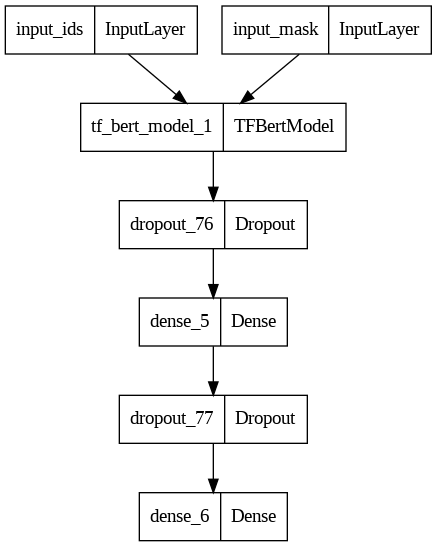

In [ ]:
model = get_model()
tf.keras.utils.plot_model(model)

In [ ]:
from keras.callbacks import EarlyStopping
history = model.fit(x = {'input_ids':X_train_tokens['input_ids'],'input_mask':X_train_tokens['attention_mask']}, y = y_train, epochs=3, validation_split = 0.2, batch_size = 64, callbacks=[EarlyStopping( monitor='val_accuracy' ,mode='max', patience=3,verbose=False,restore_best_weights=True)])

Epoch 1/3
500/500 [==============================] - 9649s 19s/step - loss: 0.4954 - accuracy: 0.7584 - val_loss: 0.4304 - val_accuracy: 0.8098
Epoch 2/3
500/500 [==============================] - 9619s 19s/step - loss: 0.4117 - accuracy: 0.8198 - val_loss: 0.4201 - val_accuracy: 0.8124
Epoch 3/3
 62/500 [==>...........................] - ETA: 2:09:39 - loss: 0.3947 - accuracy: 0.8334

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

In [ ]:
ratio_train = 0.8
ratio_val = 0.1
ratio_test = 0.1
X_remain,X_test=train_test_split(
            data, test_size=ratio_test)
ratio_remaining = 1 - ratio_test
X_train,X_val=train_test_split(
          X_remain, test_size=ratio_val_adjusted)

dataset = tf.data.Dataset.from_tensor_slices(data)
dataset_val= tf.data.Dataset.from_tensor_slices(X_val)
dataset_test= tf.data.Dataset.from_tensor_slices(X_test)

ValueError: ignored

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(data)

ValueError: ignored

In [ ]:
df=df.drop(columns=['id','date','flag','user'])

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(tf.cast(df))

TypeError: ignored

In [ ]:
ratio_train = 0.8
ratio_val = 0.1
ratio_test = 0.1

# Produces test split.
X_remaining, X_test, y_remaining, y_test = train_test_split(
            df_text, df_target, test_size=ratio_test)

        # Adjusts val ratio, w.r.t. remaining dataset.
ratio_remaining = 1 - ratio_test
ratio_val_adjusted = ratio_val / ratio_remaining
X_train, X_val, y_train, y_val = train_test_split(
          X_remaining, y_remaining, test_size=ratio_val_adjusted)




dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset_val= tf.data.Dataset.from_tensor_slices((X_val, y_val))
dataset_test= tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [ ]:
train_ds = dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
val_ds = dataset_val.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
test_ds = dataset_test.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
!pip install tensorflow-text

In [ ]:
!pip install tf-models-official

In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.762629    0.99280983 -0.18611868  0.36673862  0.15233733  0.6550447
  0.9681154  -0.9486271   0.00216128 -0.9877732   0.06842692 -0.97630584]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946346  0.3432128   0.33231518 ...  0.21300825  0.7102068
  -0.05771117]
 [-0.28742072  0.31981036 -0.23018576 ...  0.58455    -0.21329743
   0.72692114]
 [-0.66157067  0.68876773 -0.8743301  ...  0.1087725  -0.26173177
   0.47855407]
 ...
 [-0.2256118  -0.2892561  -0.0706445  ...  0.47566038  0.83277136
   0.40025333]
 [-0.2982428  -0.27473134 -0.05450517 ...  0.48849747  1.0955354
   0.18163396]
 [-0.44378242  0.00930811  0.07223688 ...  0.1729009   1.1833243
   0.07898017]]


In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.22171964]], shape=(1, 1), dtype=float32)


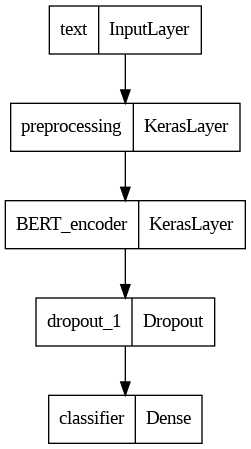

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=dataset,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5


ValueError: ignored

In [6]:
!git commit -m 'first models'

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


In [8]:
# Clone the repository
repository_name = "bad_buzz_detection"
git_repository = f"https://github.com/dibalaba/" + repository_name + ".git"
repository_path = "/content/" + repository_name
!git clone {git_repository}

# Change the current directory to the cloned directory
%cd {repository_name}

# Checkout branch
branch_name = "main"
!git checkout {branch_name}

# Pull


!git push

Cloning into 'bad_buzz_detection'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (3/3), done.
/content/bad_buzz_detection/bad_buzz_detection
Already on 'main'
Your branch is up to date with 'origin/main'.
fatal: could not read Username for 'https://github.com': No such device or address
